# Histograms of Oriented Gradients (HOG)

There are several algorithms used to detect objects in a picture. Those algorithms work well for detecting consistent internal features, such as facial detection, because faces have a lot of consistent internal features that don’t get affected by the image background, such as the eyes, nose, and mouth.

However, these type of algorithms don’t work so well when attempting to do more general object recognition, say for example, pedestrian detection in images. The reason is that people don’t have consistent internal features, like faces do, because the body shape and style of every person is different (see Fig. 1). This means that every person is going to have a different set of internal features, and so we need something that can more generally describe a person. 

![Fig. 1. - Pedestrians.](images/hog/pedestrians.jpeg)
Fig. 1. - Pedestrians.


One option is to try to detect pedestrians by their contours instead.  Detecting objects in images by their contours (boundaries) is very challenging because we have to deal with the difficulties brought about by the contrast between the background and the foreground. For example, suppose you wanted to detect a pedestrian in an image that is walking in front of a white building and she is wearing a white coat and black pants (see Fig. 2). We can see in Fig. 2, that since the background of the image is mostly white, the black pants are going to have a very high contrast, but the coat, since it is white as well, is going to have very low contrast. In this case, detecting the edges of pants is going to be easy but detecting the edges of the coat is going to be very difficult. This is where **HOG** comes in. HOG stands for **Histograms of Oriented Gradients** and it was first introduced by Navneet Dalal and Bill Triggs in 2005.

![title](images/hog/woman.jpg)
Fig. 2. - High and Low Contrast

The HOG algorithm works by **creating histograms of the distribution of gradient orientations** in an image and then normalizing them in a very special way. This special normalization is what makes HOG so effective at detecting the edges of objects even in cases where the contrast is very low. These normalized histograms are put together into a feature vector, known as the HOG descriptor, that can be used to train a machine learning algorithm, such as a Support Vector Machine (SVM), to detect objects in images based on their boundaries (edges). Due to its great success and reliability, HOG has become one of the most widely used algorithms in computer vison for object detection.

# The HOG Algorithm

As its name suggests, the HOG algorithm, is based on creating histograms from the orientation of image gradients. The HOG algorithm is implemented in a series of steps:

1. Given the image of particular object, set a detection window (region of interest) that covers the entire object in the image (see Fig. 3).

2. Calculate the magnitude and direction of the gradient for each individual pixel in the detection window.

3. Divide the detection window into connected *cells* of pixels, with all cells being of the same size (see Fig. 3). The size of the cells is a free parameter and it is usually chosen so as to match the scale of the features that want to be detected. For example, in a 64 x 128 pixel detection window, square cells 6 to 8 pixels wide are suitable for detecting human limbs.

4. Create a Histogram for each cell, by first grouping the gradient directions of all pixels in each cell into a particular number of orientation (angular) bins; and then adding up the gradient magnitudes of the gradients in each angular bin (see Fig. 3). The number of bins in the histogram is a free parameter and it is usually set to 9 angular bins.

5. Group adjacent cells into *blocks* (see Fig. 3). The number of cells in each block is a free parameter and all blocks must be of the same size. The distance between each block (known as the stride) is a free parameter but it is usually set to half the block size, in which case you will get overlapping blocks (*see video below*).  The HOG algorithm has been shown empirically to work better with overlapping blocks.

6. Use the cells contained within each block to normalize the cell histograms in that block (see Fig. 3). If you have overlapping blocks this means that most cells will be normalized with respect to different blocks (*see video below*). Therefore, the same cell may have several different normalizations.

7. Collect all the normalized histograms from all the blocks into a single feature vector called the HOG descriptor.

8. Use the resulting HOG descriptors from many images of the same type of object to train a machine learning algorithm, such as an SVM, to detect those type of objects in images. For example, you could use the HOG descriptors from many images of pedestrians to train an SVM to detect pedestrians in images. The training is done with both positive a negative examples of the object you want detect in the image.

9. Once the SVM has been trained, a sliding window approach is used to try to detect and locate objects in images.  Detecting an object in the image entails finding the part of the image that looks similar to the HOG pattern learned by the SVM.

![hog diagram](images/hog/HOG_Diagram2.png)

<figure>
<video src = "./animations/HOG Animation - Medium.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Vid. 1. - HOG Animation.</figcaption>
</figure> 

### Visualizing the algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

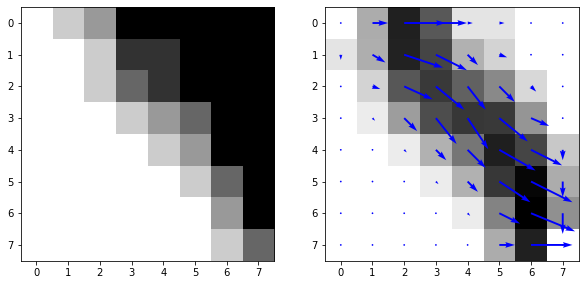

In [2]:
cell = np.array([
    [0, 1, 2, 5, 5, 5, 5, 5],
    [0, 0, 1, 4, 4, 5, 5, 5],
    [0, 0, 1, 3, 4, 5, 5, 5],
    [0, 0, 0, 1, 2, 3, 5, 5],
    [0, 0, 0, 0, 1, 2, 5, 5],
    [0, 0, 0, 0, 0, 1, 3, 5],
    [0, 0, 0, 0, 0, 0, 2, 5],
    [0, 0, 0, 0, 0, 0, 1, 3],
    ],dtype='float32')

# compute the gradients in the x and y directions:
gradx = cv2.Sobel(cell, cv2.CV_32F,1,0,ksize=3)
grady = cv2.Sobel(cell, cv2.CV_32F,0,1,ksize=3)

# compute the magnitude and angle of the gradients
norm, angle = cv2.cartToPolar(gradx,grady,angleInDegrees=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# display the image
ax1.imshow(cell, cmap='binary')

# superimpose an arrow showing the gradient magnitude and direction: 
ax2.quiver(gradx, grady, color='blue')

# display the magnitude of the gradients:
ax2.imshow(norm, cmap='binary')

### Detecting people using a HOG Descriptor

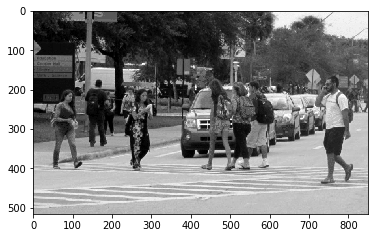

In [19]:
# Creates a hog descriptor
hog = cv2.HOGDescriptor()
# and loads the parameters for people detection
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

pedestrians = cv2.cvtColor(cv2.imread('images/hog/Distracted-Pedestrians-Crossing-a-Street.png'), cv2.COLOR_BGR2RGB)

gray_pedestrians = cv2.cvtColor(pedestrians, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_pedestrians, cmap = "gray")

When using pre-trained methods, such a HOG+SVM, it is possible that you will detect multiple bounding boxes surrounding the objects in the image. To fix this situation we’ll need to apply Non-Maximum Suppression (NMS), also called Non-Maxima Suppression.

In the context of object detection, it is used to transform a smooth response map that triggers many imprecise object window hypotheses in, ideally, a single bounding-box for each detected object.

In [20]:
# Non maximum suppression

def non_max_suppression(boxes, overlapThresh):
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
        
    # initialize the list of picked indexes    
    pick = []
    
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    # keep looping while some indexes still remain in the indexes
    # list
    
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
        
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

asd


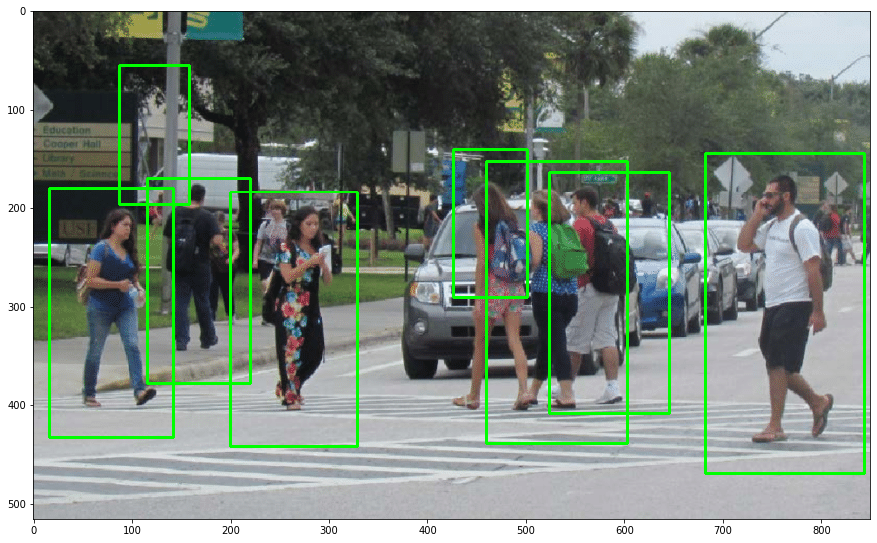

In [56]:
boxes, weights = hog.detectMultiScale(gray_pedestrians, winStride=(4, 4), padding=(8,8), scale=1.018)

boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])

# Supress additional bounding boxes using NMS
boxes = non_max_suppression(boxes, overlapThresh=0.8)

pedestrians_copy = np.copy(pedestrians)

for (xA, yA, xB, yB) in boxes:
    # display the detected boxes in the colour picture
    cv2.rectangle(pedestrians_copy, (xA, yA), (xB, yB), (0, 255, 0), 2)

plt.figure(figsize=(15,10))
plt.imshow(pedestrians_copy)